In [3]:
import math
from typing import List, Tuple, Optional, Union, Any
from functools import cmp_to_key
from data import raw

TOLERANCE = 1e-9

# Data Structures

class Vertex:
    def __init__(self, x_coord: float, y_coord: float):
        self.x = x_coord
        self.y = y_coord
        self.adj_out: List[Tuple['Vertex', int]] = []
        self.adj_in: List[Tuple['Vertex', int]] = []
        self.accumulated_weight_in = 0
        self.accumulated_weight_out = 0

    @property
    def coords(self) -> Tuple[float, float]:
        return self.x, self.y

    def __repr__(self):
        return f"V({self.x:.2f}, {self.y:.2f})"

class MonotoneChain:
    def __init__(self):
        self.path_vertices: List[Tuple[float, float]] = []
        self.path_segments: List[Tuple[Tuple[float, float], Tuple[float, float]]] = []

    def add_node(self, coords: Tuple[float, float]):
        self.path_vertices.append(coords)

    def add_segment(self, start: Tuple[float, float], end: Tuple[float, float]):
        self.path_segments.append((start, end))

class SearchTreeNode:
    def __init__(self, segments: List, chain_ref: MonotoneChain, parent: Optional['SearchTreeNode'] = None):
        self.left_child: Optional[SearchTreeNode] = None
        self.right_child: Optional[SearchTreeNode] = None
        self.parent = parent
        self.segments = segments
        self.chain_ref = chain_ref

# Geometry Utils

def cross_product(o: Tuple[float, float], a: Tuple[float, float], b: Tuple[float, float]) -> float:
    return (a[0] - o[0]) * (b[1] - o[1]) - (a[1] - o[1]) * (b[0] - o[0])

# Graph Processing

def build_graph(raw_vertices: List[Tuple[float, float]], raw_edges: List[Tuple[int, int]]) -> List[Vertex]:
    graph_nodes = [Vertex(x, y) for x, y in raw_vertices]
    for start_idx, end_idx in raw_edges:
        # Ensure edges point upwards (or rightwards for equal Y) to maintain DAG property
        u, v = sorted((start_idx, end_idx))
        node_u = graph_nodes[u]
        node_v = graph_nodes[v]
        node_u.adj_out.append((node_v, 1))
        node_v.adj_in.append((node_u, 1))
    return graph_nodes

def compute_planar_weights(graph: List[Vertex]):
    for node in graph:
        center = node.coords
        
        # Sort edges angularly to identify "leftmost" and "rightmost" paths
        def angular_comparator(edge1, edge2):
            p1 = edge1[0].coords
            p2 = edge2[0].coords
            cp = cross_product(center, p1, p2)
            if math.isclose(cp, 0, abs_tol=TOLERANCE): return 0
            return -1 if cp > 0 else 1

        node.adj_out.sort(key=cmp_to_key(angular_comparator))
        node.adj_in.sort(key=cmp_to_key(lambda a, b: -1 * angular_comparator(a, b)))

    # Forward pass: Propagate weights from bottom to top
    for i in range(1, len(graph) - 1):
        v = graph[i]
        v.accumulated_weight_in = sum(w for _, w in v.adj_in)
        v.accumulated_weight_out = len(v.adj_out)
        
        # if input flow > output flow, push excess to leftmost outgoing edge
        if v.accumulated_weight_in > v.accumulated_weight_out:
            target_node, current_w = v.adj_out.pop(0)
            new_weight = current_w + v.accumulated_weight_in - v.accumulated_weight_out
            v.adj_out.insert(0, (target_node, new_weight))
            
            # Update the corresponding incoming edge at the target node
            for idx, (neighbor, w) in enumerate(target_node.adj_in):
                if neighbor == v:
                    target_node.adj_in[idx] = (v, new_weight)
                    break

    # Backward pass: Propagate weights from top to bottom
    for i in range(len(graph) - 2, 0, -1):
        v = graph[i]
        v.accumulated_weight_in = sum(w for _, w in v.adj_in)
        v.accumulated_weight_out = sum(w for _, w in v.adj_out)
        
        # If output flow > input flow, pull excess from leftmost incoming edge
        if v.accumulated_weight_out > v.accumulated_weight_in:
            source_node, current_w = v.adj_in.pop(0)
            new_weight = current_w + v.accumulated_weight_out - v.accumulated_weight_in
            v.adj_in.insert(0, (source_node, new_weight))
            
            for idx, (neighbor, w) in enumerate(source_node.adj_out):
                if neighbor == v:
                    source_node.adj_out[idx] = (v, new_weight)
                    break

def generate_monotone_chains(graph: List[Vertex]) -> List[MonotoneChain]:
    source_node = graph[0]
    total_chains = sum(w for _, w in source_node.adj_out)
    chains = [MonotoneChain() for _ in range(total_chains)]
    
    for chain in chains:
        current_v = source_node
        
        # Traverse graph greedily consuming edge weights
        while current_v.adj_out:
            chain.add_node(current_v.coords)
            chosen_idx = -1
            
            # Pick the rightmost available edge (non-zero weight)
            for i in range(len(current_v.adj_out) - 1, -1, -1):
                neighbor, weight = current_v.adj_out[i]
                if weight > 0:
                    chosen_idx = i
                    break
            if chosen_idx == -1: break
            
            next_v, w = current_v.adj_out[chosen_idx]
            current_v.adj_out[chosen_idx] = (next_v, w - 1) # Decrease capacity
            current_v = next_v
            
        chain.add_node(current_v.coords)
        
        verts = chain.path_vertices
        for k in range(len(verts) - 1):
            chain.add_segment(verts[k], verts[k+1])
    return chains

def create_search_structure(chains: List[MonotoneChain], parent: Optional[SearchTreeNode] = None) -> Optional[SearchTreeNode]:
    if not chains: return None
    mid_idx = len(chains) // 2
    median_chain = chains[mid_idx]
    
    node = SearchTreeNode(median_chain.path_segments, median_chain, parent)
    node.left_child = create_search_structure(chains[:mid_idx], node)
    node.right_child = create_search_structure(chains[mid_idx + 1:], node)
    return node

# Query Logic

def find_position_relative_to_chain(point: Tuple[float, float], node: SearchTreeNode) -> int:
    px, py = point
    segments = node.segments
    target_segment = None
    
    # Binary Search to find the segment covering the point's Y-coordinate
    left_idx, right_idx = 0, len(segments) - 1
    
    while left_idx <= right_idx:
        mid_idx = (left_idx + right_idx) // 2
        p1, p2 = segments[mid_idx]
        
        y_min, y_max = p1[1], p2[1]
        
        if y_min - TOLERANCE <= py <= y_max + TOLERANCE:
            target_segment = (p1, p2)
            break
        elif py < y_min:
            right_idx = mid_idx - 1
        else:
            left_idx = mid_idx + 1
            
    if target_segment is None: 
        return 1
    
    cp = cross_product(target_segment[0], target_segment[1], point)
    
    if math.isclose(cp, 0, abs_tol=TOLERANCE):
        # Handle collinear points: check if strictly inside segment bounds
        min_x = min(target_segment[0][0], target_segment[1][0])
        max_x = max(target_segment[0][0], target_segment[1][0])
        if min_x <= px <= max_x:
            return 0 
        return -1 if px > target_segment[0][0] else 1
    
    # Return -1 for Right, 1 for Left
    return -1 if cp < 0 else 1

def query_search_tree(point: Tuple[float, float], node: Optional[SearchTreeNode], 
                     closest_left: Optional[MonotoneChain] = None,
                     closest_right: Optional[MonotoneChain] = None) -> Union[MonotoneChain, Tuple[MonotoneChain, MonotoneChain]]:
    if node is None:
        return (closest_left, closest_right)
        
    position = find_position_relative_to_chain(point, node)
    
    if position == 0:
        return node.chain_ref
        
    # Traverse BST based on point position relative to current separator
    if position < 0:
        return query_search_tree(point, node.right_child, closest_left=node.chain_ref, closest_right=closest_right)
    else: 
        return query_search_tree(point, node.left_child, closest_left=closest_left, closest_right=node.chain_ref)

def extract_region_edges(chain_a: MonotoneChain, chain_b: MonotoneChain, point: Tuple[float, float]) -> List[Tuple]:
    if chain_a is None: return chain_b.path_segments 
    if chain_b is None: return chain_a.path_segments

    verts_a = chain_a.path_vertices
    verts_b = chain_b.path_vertices
    
    bubbles = []
    i, j = 0, 0
    last_common_a_idx = 0
    last_common_b_idx = 0
    
    # Iterate through both chains to find split and merge points ("bubbles")
    while i < len(verts_a) and j < len(verts_b):
        va = verts_a[i]
        vb = verts_b[j]
        
        is_same = math.isclose(va[0], vb[0], abs_tol=TOLERANCE) and math.isclose(va[1], vb[1], abs_tol=TOLERANCE)
        
        if is_same:
            if i > last_common_a_idx or j > last_common_b_idx:
                # Close the bubble and store it
                bubble_a = verts_a[last_common_a_idx : i+1]
                bubble_b = verts_b[last_common_b_idx : j+1]
                bubbles.append((bubble_a, bubble_b))
                
            last_common_a_idx = i
            last_common_b_idx = j
            i += 1
            j += 1
        else:
            # Advance pointer for the geometrically lower vertex
            if va[1] < vb[1] or (math.isclose(va[1], vb[1]) and va[0] < vb[0]):
                i += 1
            else:
                j += 1
                
    py = point[1]
    result_edges = []
    
    # Find which bubble contains the query point Y-coordinate
    for path_a, path_b in bubbles:
        min_y = min(v[1] for v in path_a + path_b)
        max_y = max(v[1] for v in path_a + path_b)
        
        if min_y <= py <= max_y:
            # Collect unique edges from both sides of the bubble
            for k in range(len(path_a) - 1):
                result_edges.append((path_a[k], path_a[k+1]))
            for k in range(len(path_b) - 1):
                edge = (path_b[k], path_b[k+1])
                if edge not in result_edges:
                    result_edges.append(edge)
            if result_edges:
                return result_edges

    return result_edges

# Main API

def run_point_location(vertices: List[Tuple[float, float]], edges: List[Tuple[int, int]], query_point: Tuple[float, float]):
    graph = build_graph(vertices, edges)
    compute_planar_weights(graph)
    separators = generate_monotone_chains(graph)
    bst_root = create_search_structure(separators)
    
    result = query_search_tree(query_point, bst_root, closest_left=separators[0], closest_right=separators[-1])
    
    # Handle point exactly on a separator
    if isinstance(result, MonotoneChain):
        segments = result.path_segments
        l, r = 0, len(segments) - 1
        while l <= r:
            mid = (l + r) // 2
            seg = segments[mid]
            if seg[0][1] <= query_point[1] <= seg[1][1]:
                return [seg]
            elif query_point[1] < seg[0][1]:
                r = mid - 1
            else:
                l = mid + 1
        return result.path_segments
        
    # Handle point inside a region
    sep_left, sep_right = result
    return extract_region_edges(sep_left, sep_right, query_point)

def separators_method_point_location_algorithm_visualiser(raw_vertices, raw_edges, point):
    try:
        from bitalg.visualizer.main import Visualizer
    except ImportError:
        return None, run_point_location(raw_vertices, raw_edges, point)

    vis = Visualizer()
    vis.add_point(raw_vertices, color="black")
    
    segments = []
    for u, v in raw_edges:
        p1 = raw_vertices[u]
        p2 = raw_vertices[v]
        segments.append((p1, p2))
    vis.add_line_segment(segments, color="gray")
    
    found_edges = run_point_location(raw_vertices, raw_edges, point)
    
    vis.add_point(point, color="green")
    if found_edges:
        vis.add_line_segment(found_edges, color="red", linewidth=3)
        
    return vis, found_edges

In [14]:
def animate_point_location(raw_vertices: List[Tuple[float, float]], 
                           raw_edges: List[Tuple[int, int]], 
                           query_point: Tuple[float, float]):
    """
    Tworzy animację (GIF) działania algorytmu lokalizacji punktu.
    Pokazuje badany separator oraz konkretny segment, który jest sprawdzany,
    dynamicznie dodając i usuwając elementy z wizualizatora.
    """
    try:
        from bitalg.visualizer.main import Visualizer
    except ImportError:
        print("Brak biblioteki bitalg.")
        return None

    # 1. Budowa struktur
    graph = build_graph(raw_vertices, raw_edges)
    compute_planar_weights(graph)
    separators = generate_monotone_chains(graph)
    bst_root = create_search_structure(separators)
    
    # 2. Inicjalizacja wizualizatora
    vis = Visualizer()
    
    # TŁO: Rysujemy cały graf na szaro (stały element)
    vis.add_point(raw_vertices, color="black", s=5)
    
    all_segments = []
    for u, v in raw_edges:
        p1 = raw_vertices[u]
        p2 = raw_vertices[v]
        all_segments.append((p1, p2))
    vis.add_line_segment(all_segments, color="lightgray", linewidth=1)
    
    # PUNKT: Szukany punkt na zielono (stały element)
    vis.add_point([query_point], color="green", s=20)
    
    # 3. Pętla animacji (przechodzenie przez drzewo)
    current_node = bst_root
    
    while current_node is not None:
        # A. Pokaż cały aktualny SEPARATOR (Pomarańczowy)
        chain_segments = current_node.segments
        # Zapisujemy ID figury, żeby ją potem usunąć
        chain_fig = vis.add_line_segment(chain_segments, color="orange", linewidth=2)
        
        # B. Znajdź konkretny SEGMENT (krawędź) na tym separatorze (Binary Search)
        px, py = query_point
        target_segment = None
        left_idx, right_idx = 0, len(chain_segments) - 1
        
        while left_idx <= right_idx:
            mid_idx = (left_idx + right_idx) // 2
            p1, p2 = chain_segments[mid_idx]
            y_min, y_max = p1[1], p2[1]
            
            if y_min - TOLERANCE <= py <= y_max + TOLERANCE:
                target_segment = (p1, p2)
                break
            elif py < y_min:
                right_idx = mid_idx - 1
            else:
                left_idx = mid_idx + 1
        
        seg_fig = None
        position = 1 # Domyślnie prawo (fallback)

        if target_segment:
            # C. Pokaż sprawdzany SEGMENT (Niebieski, gruby)
            seg_fig = vis.add_line_segment([target_segment], color="blue", linewidth=4)
            
            # Oblicz stronę (logika algorytmu)
            cp = cross_product(target_segment[0], target_segment[1], query_point)
            if math.isclose(cp, 0, abs_tol=TOLERANCE):
                position = 0 # Na krawędzi
            else:
                position = -1 if cp < 0 else 1
        
        # D. USUWANIE (To tworzy "klatkę" animacji)
        # Usuwamy elementy po ich wyświetleniu, co symuluje ruch przy generowaniu GIFa.
        if seg_fig:
            vis.remove_figure(seg_fig)
        
        vis.remove_figure(chain_fig)
        
        # E. Decyzja - gdzie idziemy dalej?
        if position == 0:
            break # Znaleziono (na krawędzi)
        elif position < 0:
            current_node = current_node.right_child
        else:
            current_node = current_node.left_child

    # 4. Finał: Pokaż wynikowy obszar na czerwono (zostaje na stałe)
    found_edges = run_point_location(raw_vertices, raw_edges, query_point)
    if found_edges:
        vis.add_line_segment(found_edges, color="red", linewidth=3)
        
    return vis

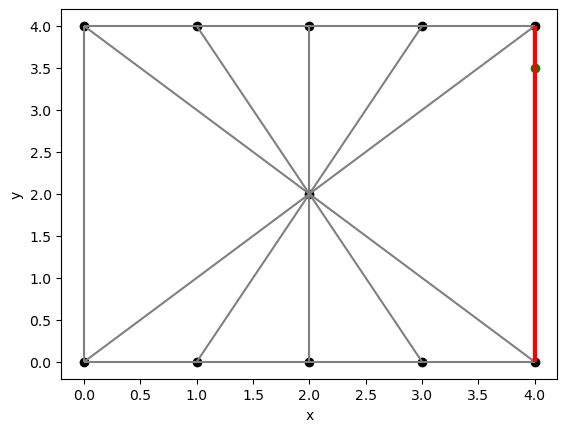

In [7]:
from data import raw
point1=(4,3.5)
vis1,e=separators_method_point_location_algorithm_visualiser(raw.test1_vertices, raw.test1_edges,point1)
vis1.show()


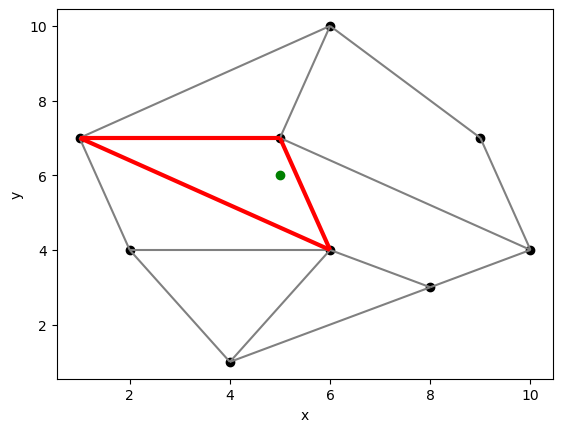

In [10]:

point3=(5,6)
vis3,e=separators_method_point_location_algorithm_visualiser(raw.vertices, raw.edges,point3)
vis3.show()

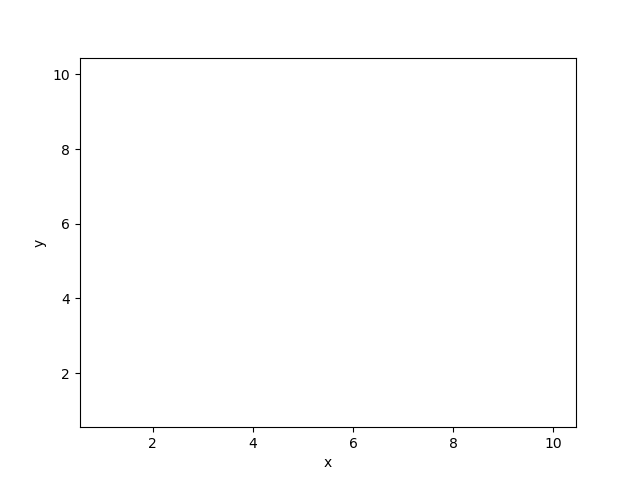

In [17]:
# Przykład użycia
vis_anim = generate_search_animation(raw.vertices, raw.edges, point3)
vis_anim.show_gif() # Jeśli chcesz zapisać/pokazać jako animację



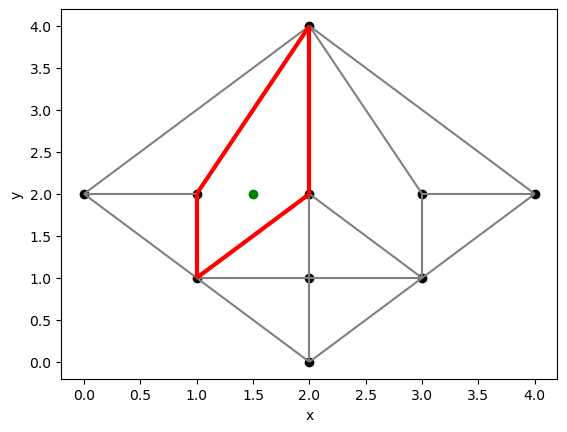

In [24]:
point2=(1.5,2)
vis2,edges=separators_method_point_location_algorithm_visualiser(raw.test2_vertices, raw.test2_edges,point2)
vis2.show()

In [36]:
import random
import matplotlib.pyplot as plt
import os  # <--- NOWY IMPORT: Potrzebny do obsługi folderów i ścieżek

# --- Generatory Grafów (Bez zmian) ---

def generate_tri_grid(width, height):
    # ... (kod generatora bez zmian) ...
    vertices = []
    edges = []
    for y in range(height + 1):
        for x in range(width + 1):
            vertices.append((float(x), float(y)))
    def get_idx(x, y):
        return y * (width + 1) + x
    for y in range(height):
        for x in range(width):
            u = get_idx(x, y)
            right = get_idx(x + 1, y)
            top = get_idx(x, y + 1)
            top_right = get_idx(x + 1, y + 1)
            edges.append((u, right))
            edges.append((u, top))
            edges.append((right, top_right))
            edges.append((top, top_right))
            edges.append((u, top_right))
    unique_edges = set()
    for u, v in edges:
        if u < v: unique_edges.add((u, v))
        else: unique_edges.add((v, u))
    return vertices, list(unique_edges), 0

def generate_quad_grid(width, height, skew=0.0):
    # ... (kod generatora bez zmian) ...
    vertices = []
    edges = []
    for y in range(height + 1):
        shift = y * skew
        for x in range(width + 1):
            vertices.append((float(x + shift), float(y)))
    def get_idx(x, y):
        return y * (width + 1) + x
    for y in range(height + 1):
        for x in range(width):
            u = get_idx(x, y)
            v = get_idx(x + 1, y)
            edges.append((u, v))
    for x in range(width + 1):
        for y in range(height):
            u = get_idx(x, y)
            v = get_idx(x, y + 1)
            edges.append((u, v))
    unique_edges = set()
    for u, v in edges:
        if u < v: unique_edges.add((u, v))
        else: unique_edges.add((v, u))
    return vertices, list(unique_edges), skew

# --- Definicja Scenariuszy (Bez zmian) ---

scenarios = [
    {"gen": lambda: generate_quad_grid(3, 3, skew=0.0), "dims": (3, 3), "desc": "Siatka 3x3 (Kwadraty)"},
    {"gen": lambda: generate_quad_grid(4, 2, skew=0.5), "dims": (4, 2), "desc": "Siatka 4x2 (Równoległoboki)"},
    {"gen": lambda: generate_tri_grid(2, 5), "dims": (2, 5), "desc": "Siatka 2x5 (Trójkąty)"},
    {"gen": lambda: generate_tri_grid(5, 5), "dims": (5, 5), "desc": "Siatka 5x5 (Trójkąty)"},
    {"gen": lambda: generate_tri_grid(6, 4), "dims": (6, 4), "desc": "Siatka 6x4 (Trójkąty)"}
]

# --- Pętla Testowa z Zapisem GIF ---

# 1. Konfiguracja folderu wyjściowego
output_folder = "gif"

# Sprawdź czy folder istnieje, jeśli nie - utwórz go
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"Utworzono folder: '{output_folder}'")
else:
    print(f"Folder '{output_folder}' już istnieje.")

print("Rozpoczynam generowanie animacji...")

for s_idx, scen in enumerate(scenarios):
    desc = scen["desc"]
    w, h = scen["dims"]
    print(f"\n--- Przetwarzanie scenariusza {s_idx}: {desc} ---")
    
    # Generowanie grafu
    vertices, edges, skew = scen["gen"]()
    
    # Generowanie 2 losowych punktów
    points_to_check = []
    for _ in range(2):
        py = random.uniform(0, h)
        shift_at_y = py * skew 
        px = random.uniform(0 + shift_at_y, w + shift_at_y)
        points_to_check.append((px, py))
        
    # Uruchomienie animacji dla punktów
    for p_idx, point in enumerate(points_to_check):
        print(f"  Generowanie animacji dla punktu {p_idx}...")
        try:
            # --- ZAKŁADAMY ISTNIENIE FUNKCJI animate_point_location ---
            # Funkcja ta musi zwracać obiekt, który posiada metodę .save_gif(ścieżka)
            vis_anim = animate_point_location(
                vertices, 
                edges, 
                point
            )
            
            if vis_anim:
                # 2. Tworzenie czytelnej nazwy pliku
                # Używamy f-stringa z formatowaniem :02d, żeby liczby jednocyfrowe miały zero z przodu (np. 01, 02)
                filename = f"scenariusz_{s_idx:02d}_punkt_{p_idx}.gif"
                
                # 3. Łączenie ścieżki folderu z nazwą pliku
                full_path = os.path.join(output_folder, filename)
                
                # Zapisanie GIFa pod nową ścieżką
                vis_anim.save_gif(full_path)
                print(f"    -> Zapisano: {full_path}")
            
        except NameError:
             print("\n[BŁĄD KRYTYCZNY] Funkcja 'animate_point_location' nie jest zdefiniowana.")
             print("Upewnij się, że uruchomiłaś komórkę z definicją tej funkcji przed uruchomieniem tej pętli.")
             break # Przerywamy pętlę, bo nic nie zadziała
        except Exception as e:
            print(f"    [BŁĄD] Nie udało się wygenerować animacji: {e}")

print("\nZakończono.")

Utworzono folder: 'gif'
Rozpoczynam generowanie animacji...

--- Przetwarzanie scenariusza 0: Siatka 3x3 (Kwadraty) ---
  Generowanie animacji dla punktu 0...
    -> Zapisano: gif\scenariusz_00_punkt_0.gif
  Generowanie animacji dla punktu 1...
    -> Zapisano: gif\scenariusz_00_punkt_1.gif

--- Przetwarzanie scenariusza 1: Siatka 4x2 (Równoległoboki) ---
  Generowanie animacji dla punktu 0...
    -> Zapisano: gif\scenariusz_01_punkt_0.gif
  Generowanie animacji dla punktu 1...
    -> Zapisano: gif\scenariusz_01_punkt_1.gif

--- Przetwarzanie scenariusza 2: Siatka 2x5 (Trójkąty) ---
  Generowanie animacji dla punktu 0...
    -> Zapisano: gif\scenariusz_02_punkt_0.gif
  Generowanie animacji dla punktu 1...
    -> Zapisano: gif\scenariusz_02_punkt_1.gif

--- Przetwarzanie scenariusza 3: Siatka 5x5 (Trójkąty) ---
  Generowanie animacji dla punktu 0...
    -> Zapisano: gif\scenariusz_03_punkt_0.gif
  Generowanie animacji dla punktu 1...
    -> Zapisano: gif\scenariusz_03_punkt_1.gif

--- P

c:\Geometric-Algorithms-Project\bitalg\visualizer\plot\plot.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


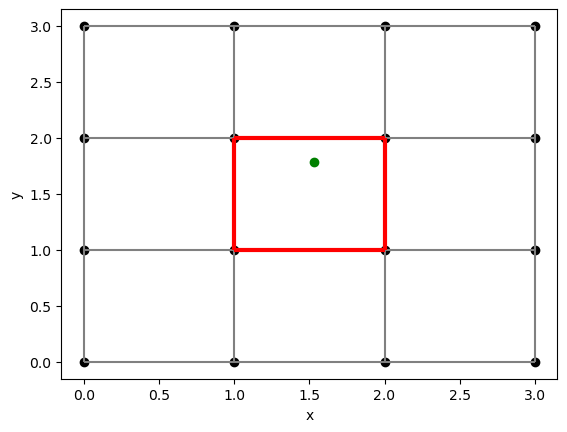

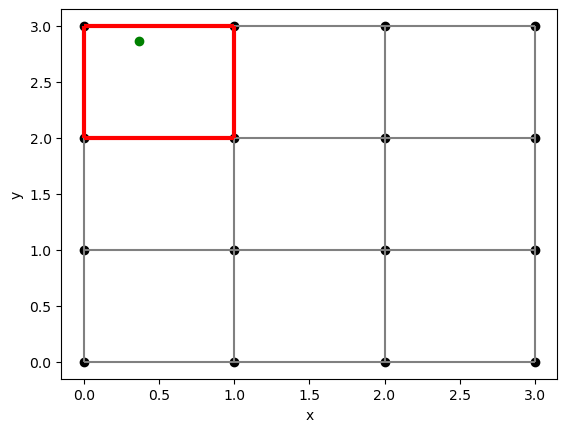

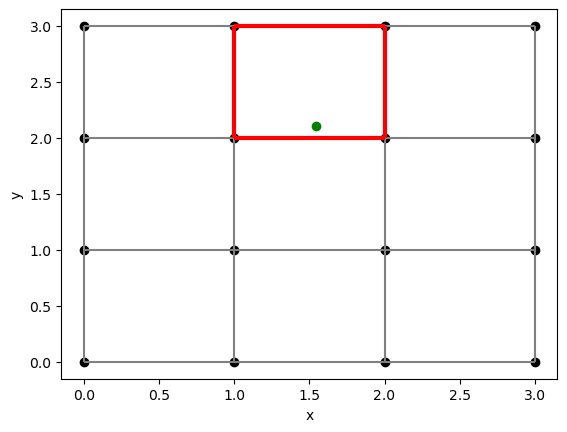

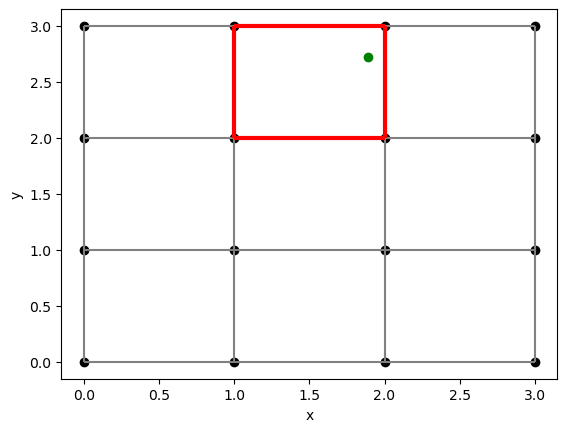

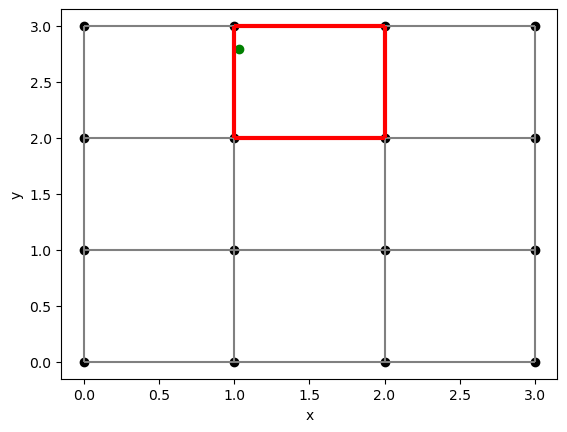

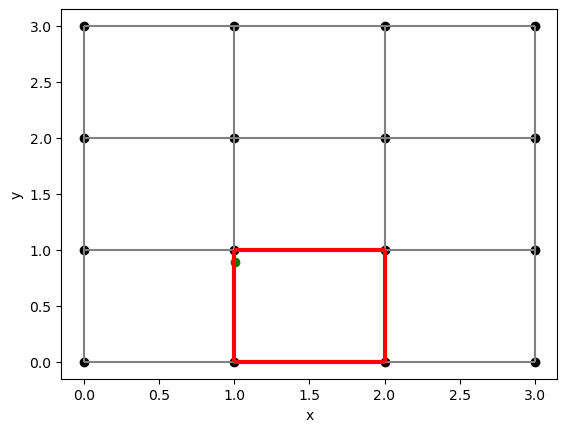

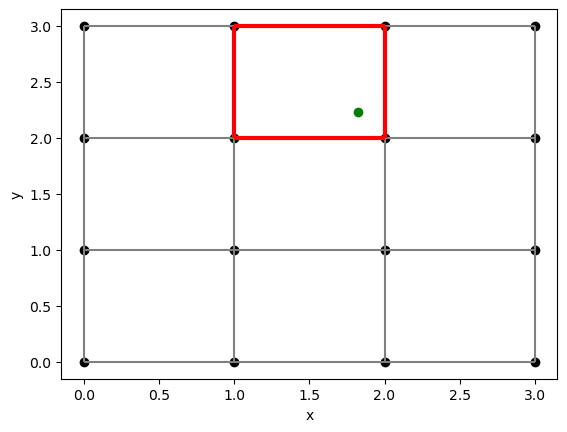

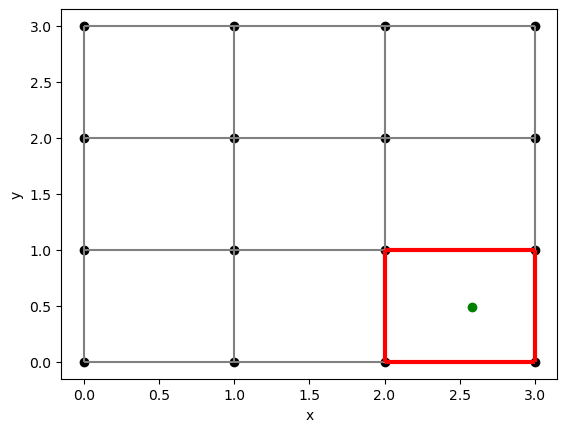

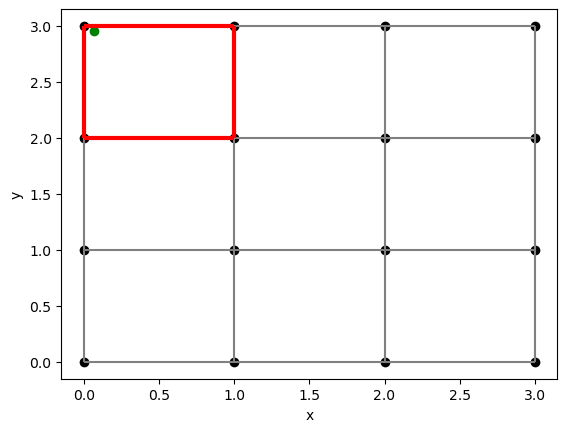

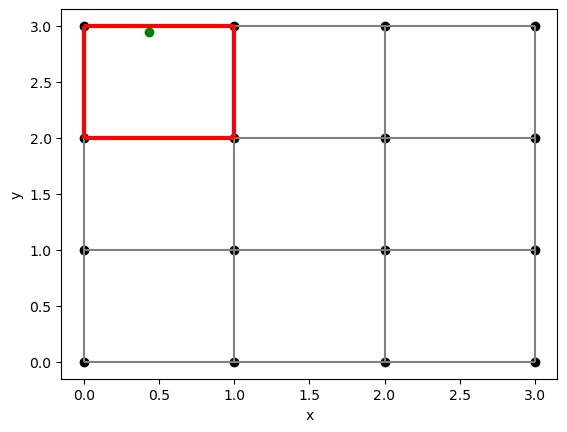

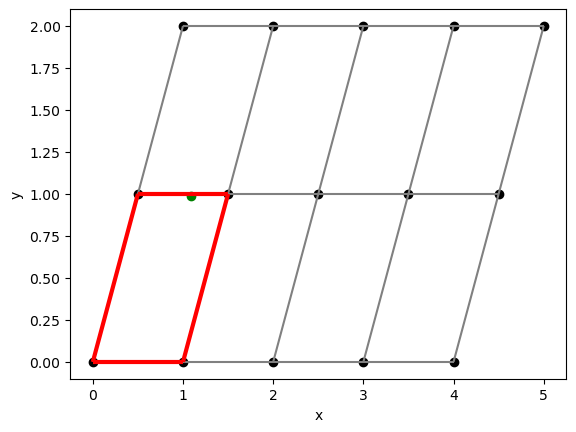

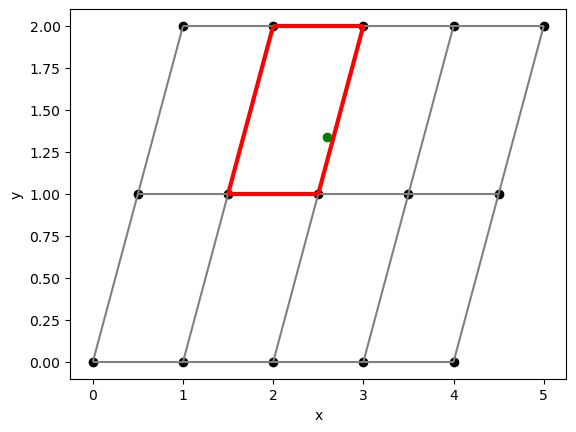

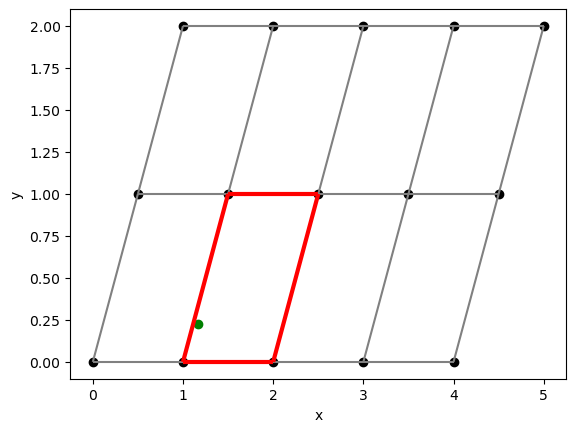

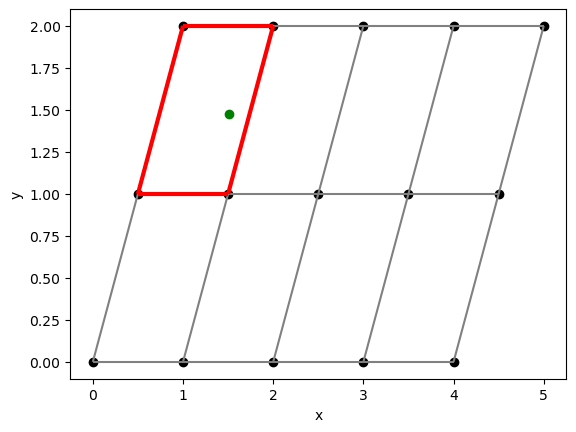

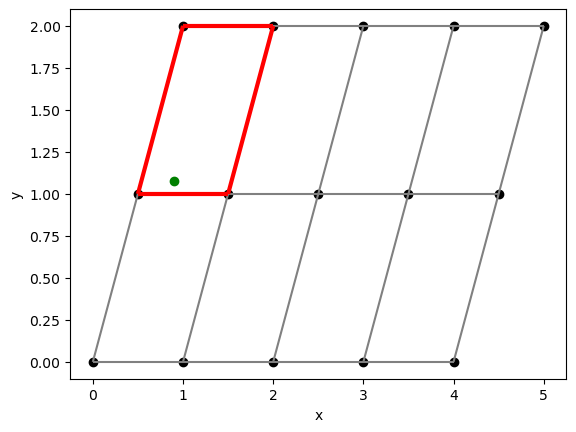

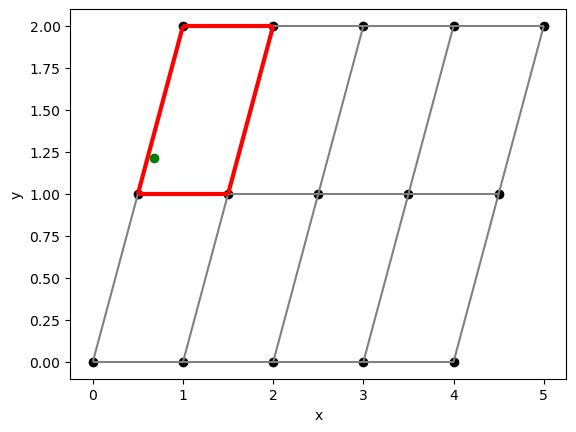

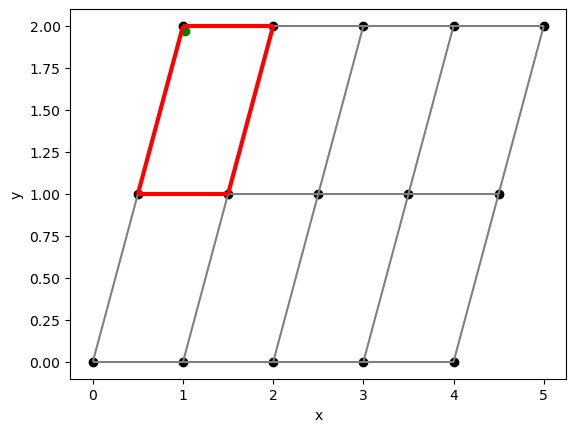

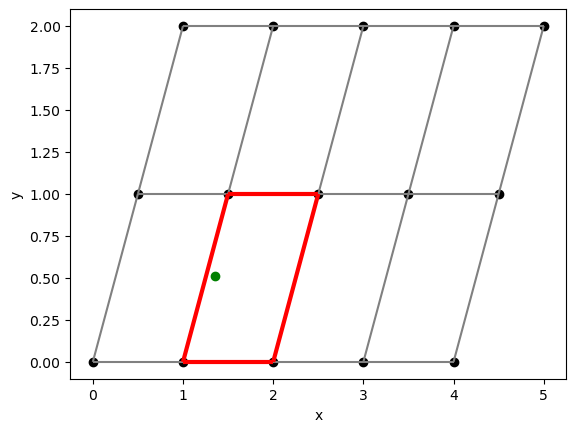

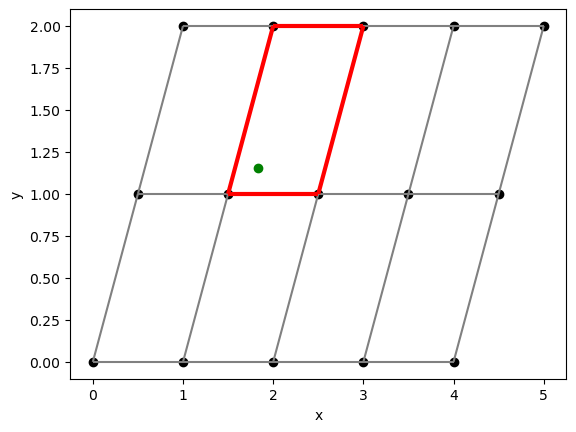

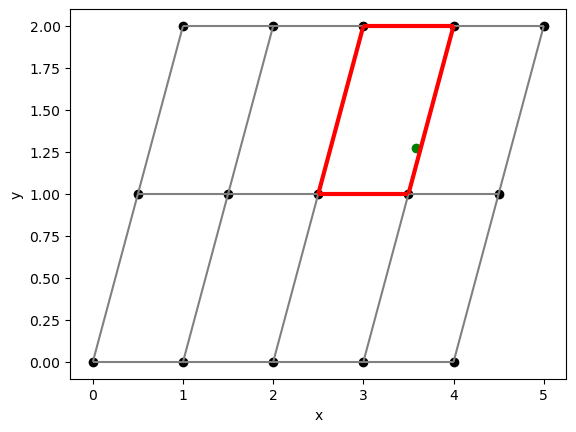

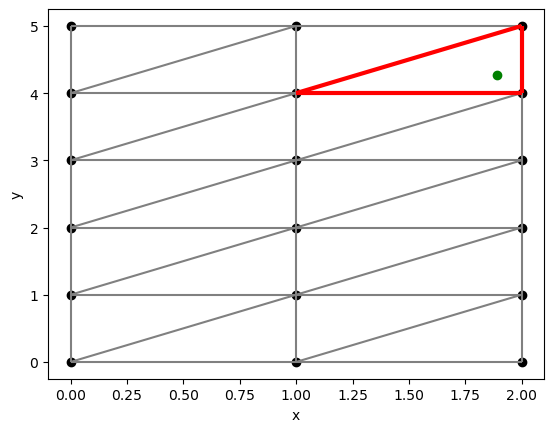

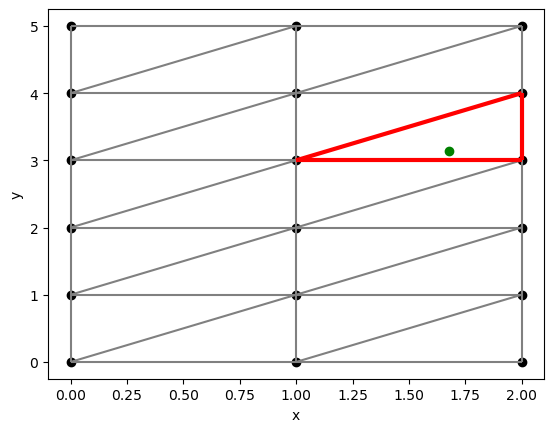

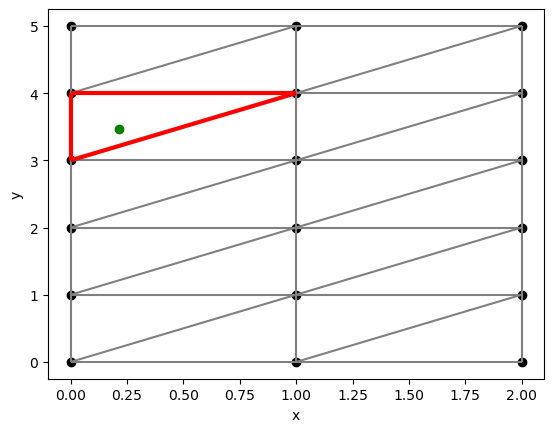

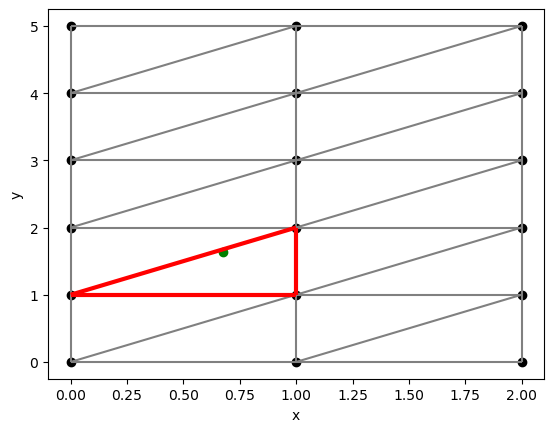

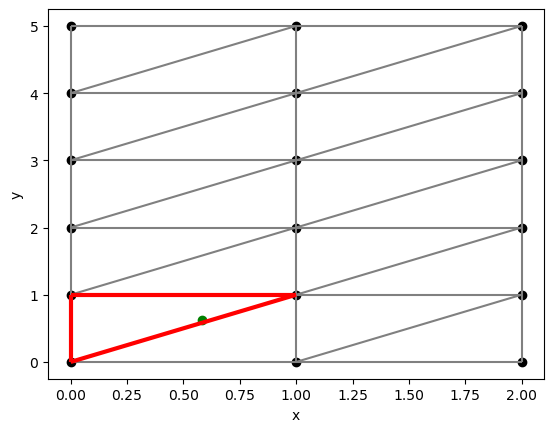

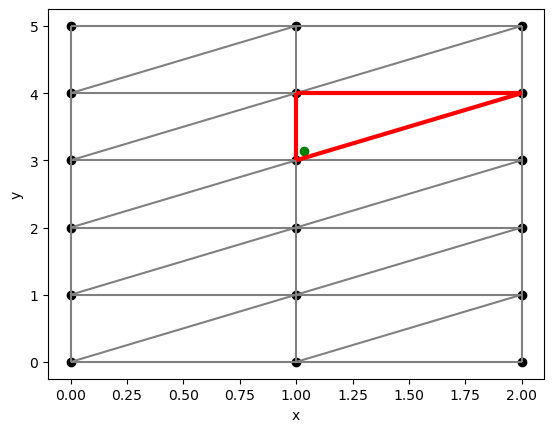

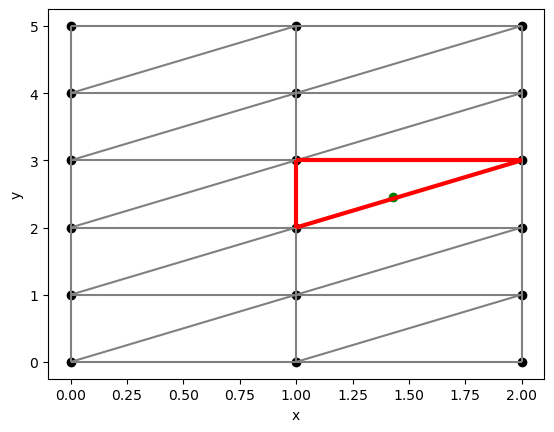

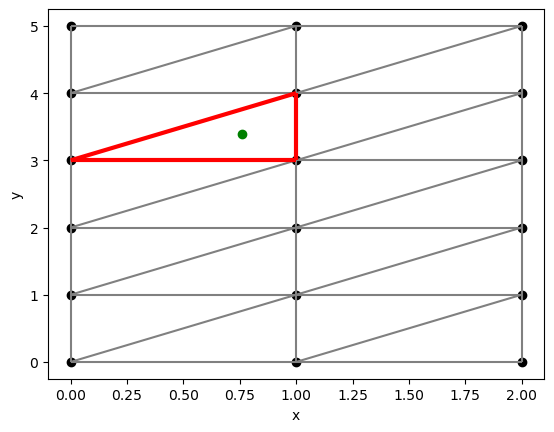

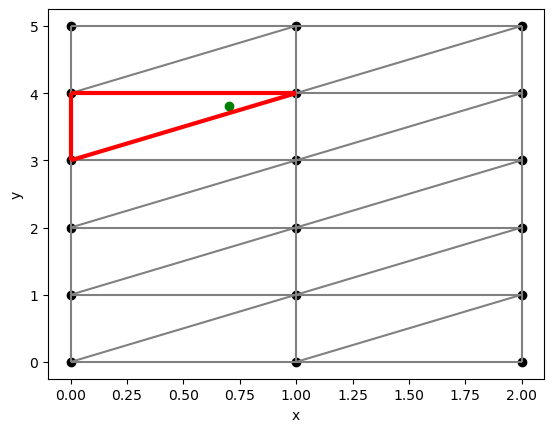

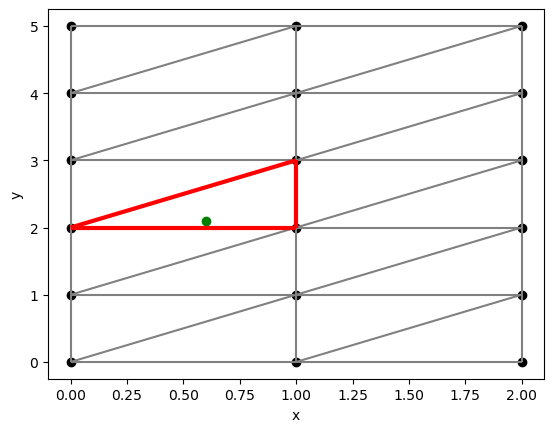

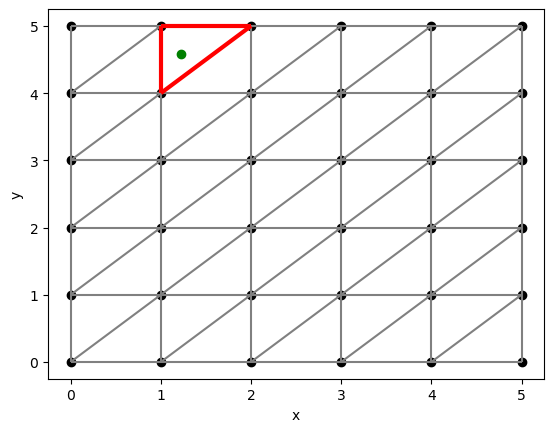

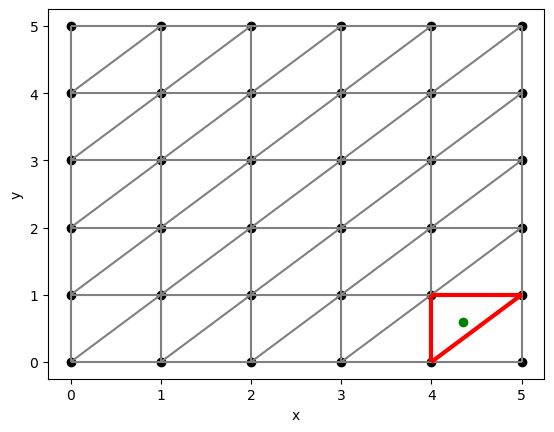

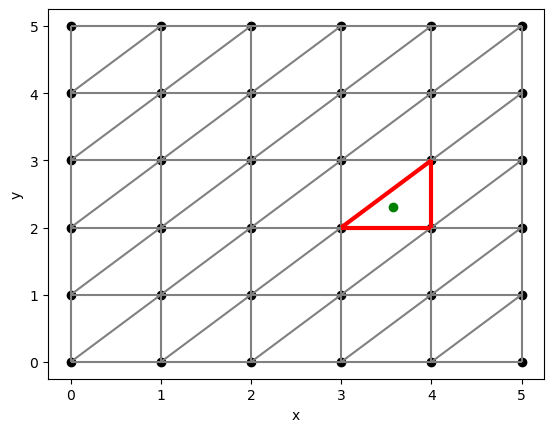

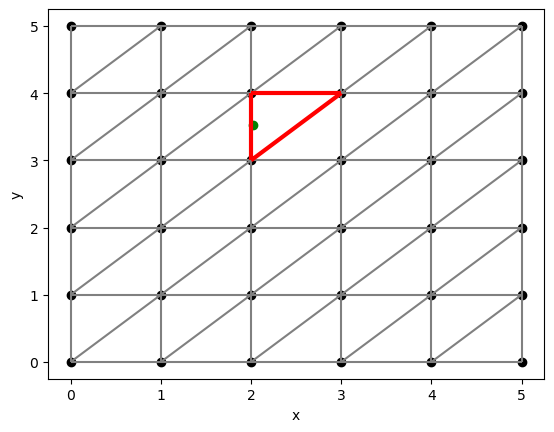

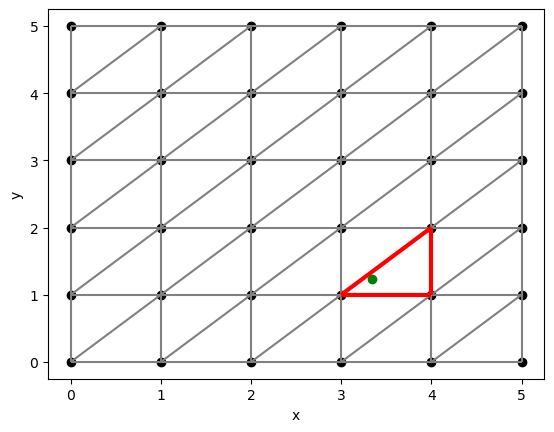

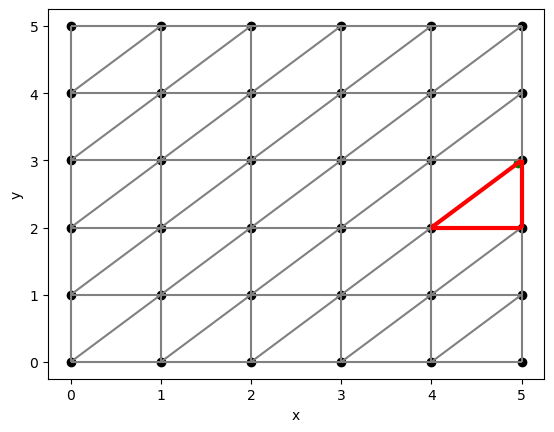

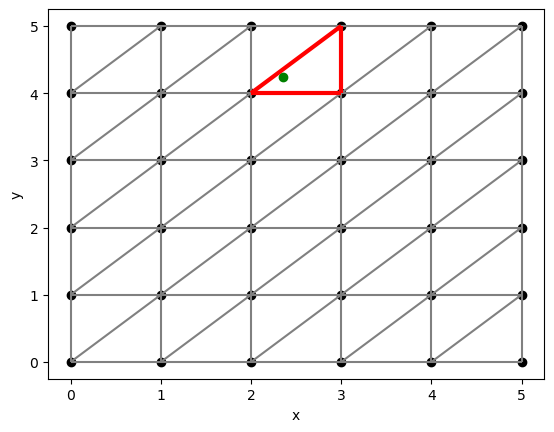

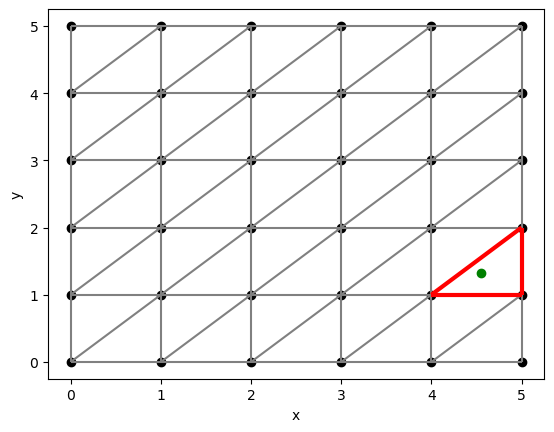

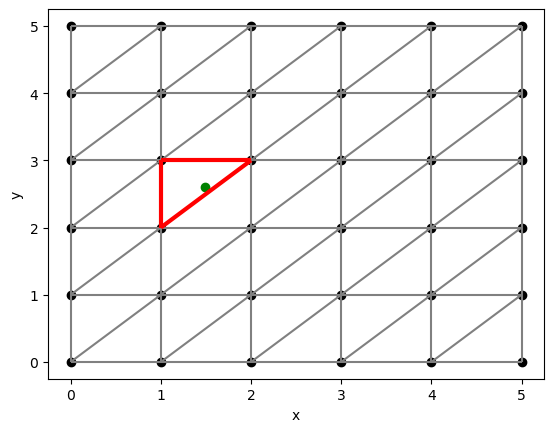

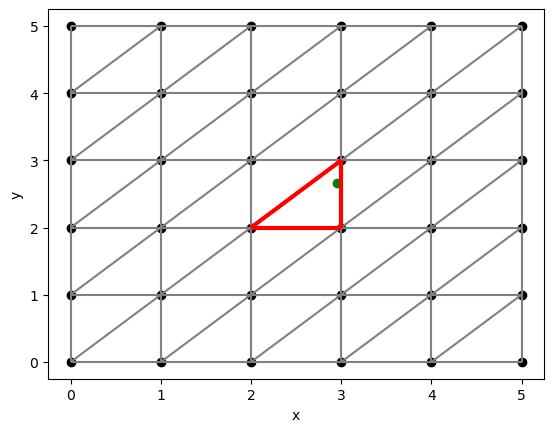

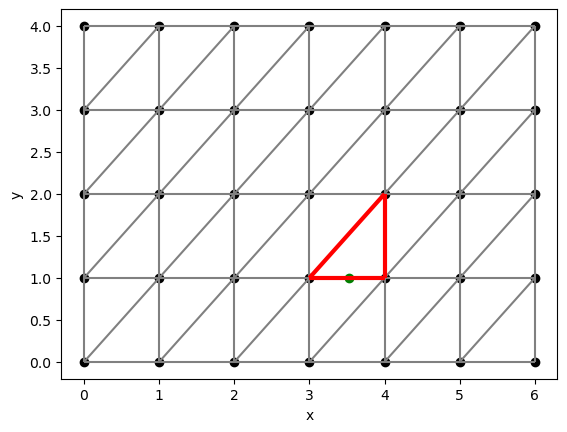

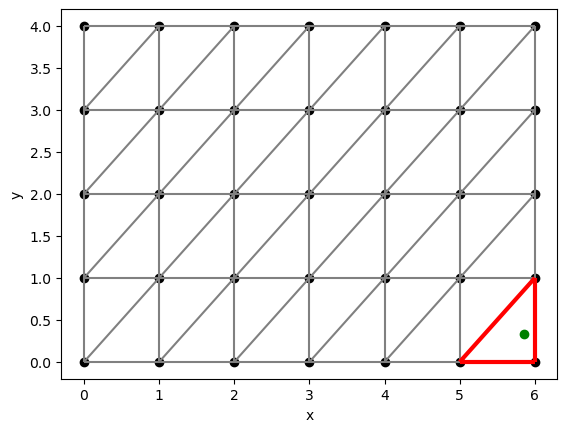

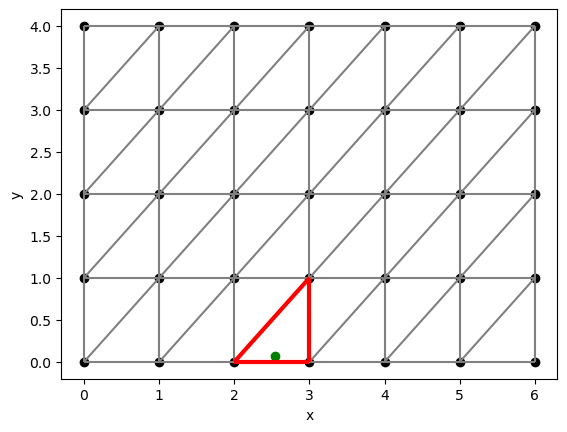

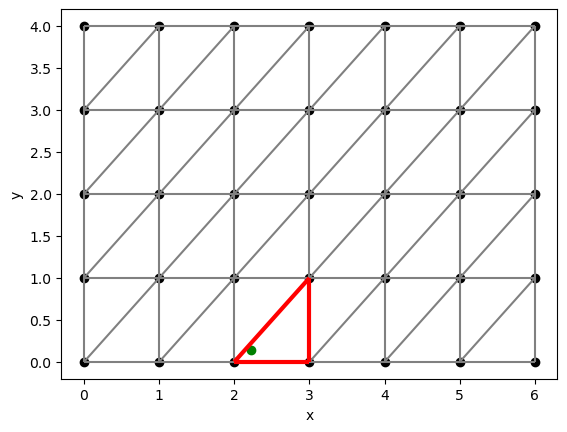

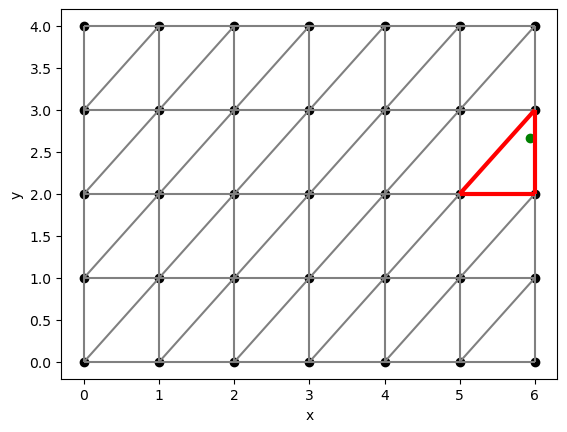

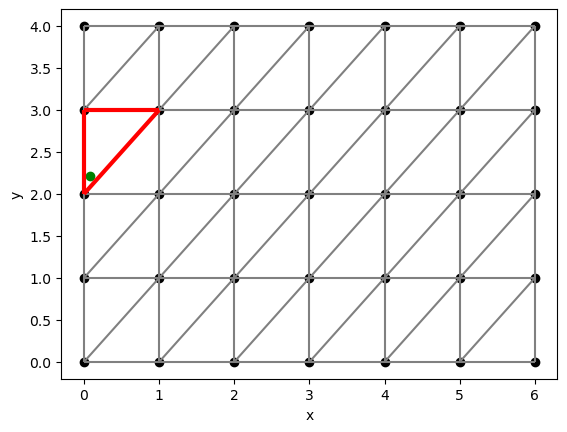

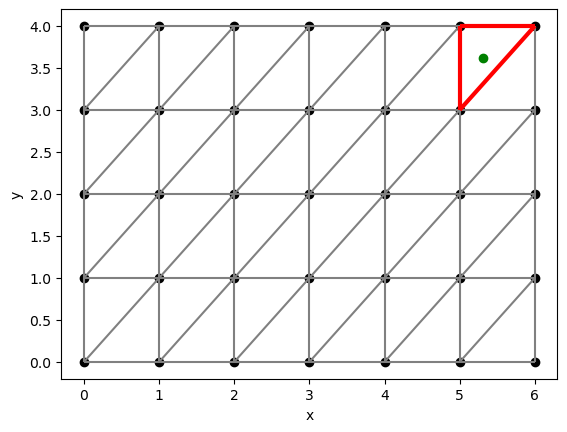

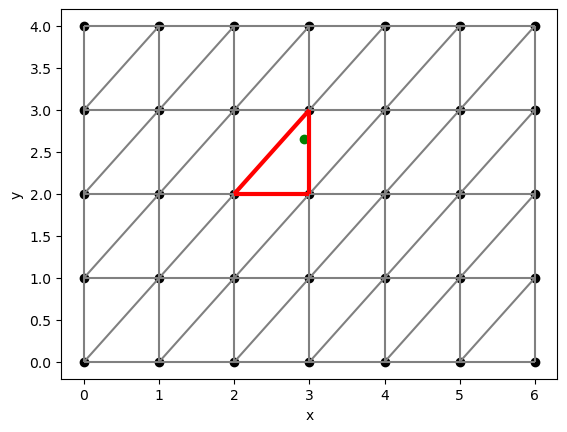

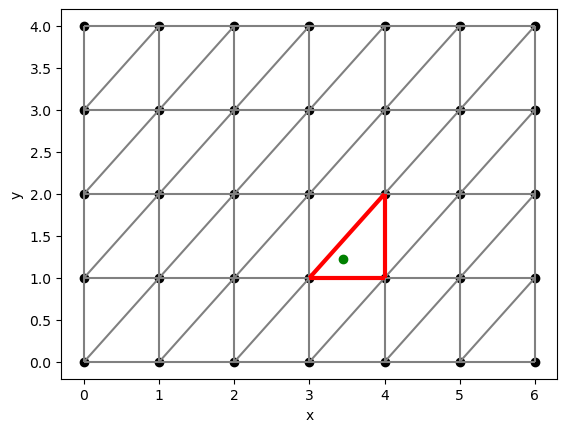

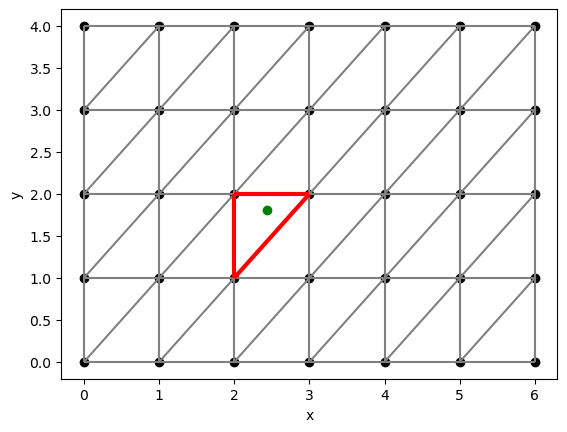

In [21]:
import random
import matplotlib.pyplot as plt

# --- Generatory Grafów ---

def generate_tri_grid(width, height):
    """
    Generuje siatkę trójkątów (oryginalna funkcja).
    """
    vertices = []
    edges = []
    
    for y in range(height + 1):
        for x in range(width + 1):
            vertices.append((float(x), float(y)))

    def get_idx(x, y):
        return y * (width + 1) + x

    for y in range(height):
        for x in range(width):
            u = get_idx(x, y)
            right = get_idx(x + 1, y)
            top = get_idx(x, y + 1)
            top_right = get_idx(x + 1, y + 1)

            edges.append((u, right))
            edges.append((u, top))
            edges.append((right, top_right))
            edges.append((top, top_right))
            edges.append((u, top_right)) # Przekątna

    unique_edges = set()
    for u, v in edges:
        if u < v: unique_edges.add((u, v))
        else: unique_edges.add((v, u))
            
    return vertices, list(unique_edges), 0 # 0 to skew (przesunięcie)

def generate_quad_grid(width, height, skew=0.0):
    """
    Generuje siatkę czworokątów (kwadraty lub równoległoboki).
    skew: parametr pochylenia siatki (0 = prosta siatka).
    """
    vertices = []
    edges = []
    
    # Wierzchołki z przesunięciem (skew)
    for y in range(height + 1):
        shift = y * skew
        for x in range(width + 1):
            vertices.append((float(x + shift), float(y)))

    def get_idx(x, y):
        return y * (width + 1) + x

    # Krawędzie (tylko poziome i pionowe/ukośne, bez przekątnych wewnątrz pola)
    # Poziome
    for y in range(height + 1):
        for x in range(width):
            u = get_idx(x, y)
            v = get_idx(x + 1, y)
            edges.append((u, v))
            
    # Pionowe (lub ukośne przy skew > 0)
    for x in range(width + 1):
        for y in range(height):
            u = get_idx(x, y)
            v = get_idx(x, y + 1)
            edges.append((u, v))

    unique_edges = set()
    for u, v in edges:
        if u < v: unique_edges.add((u, v))
        else: unique_edges.add((v, u))
            
    return vertices, list(unique_edges), skew

# --- Definicja Scenariuszy ---

scenarios = [
    # 1. Siatka Kwadratów (brak przekątnych)
    {
        "gen": lambda: generate_quad_grid(3, 3, skew=0.0), 
        "dims": (3, 3),
        "desc": "Siatka 3x3 (Kwadraty - regularne czworokąty)"
    },
    # 2. Siatka Równoległoboków (pochyła)
    {
        "gen": lambda: generate_quad_grid(4, 2, skew=0.5), 
        "dims": (4, 2),
        "desc": "Siatka 4x2 (Równoległoboki - pochylone czworokąty)"
    },
    # 3, 4, 5. Siatki Trójkątów (standardowe)
    {
        "gen": lambda: generate_tri_grid(2, 5), 
        "dims": (2, 5),
        "desc": "Siatka 2x5 (Trójkąty)"
    },
    {
        "gen": lambda: generate_tri_grid(5, 5), 
        "dims": (5, 5),
        "desc": "Siatka 5x5 (Trójkąty)"
    },
    {
        "gen": lambda: generate_tri_grid(6, 4), 
        "dims": (6, 4),
        "desc": "Siatka 6x4 (Trójkąty)"
    }
]

# --- Pętla Testowa ---

for s_idx, scen in enumerate(scenarios):
    desc = scen["desc"]
    w, h = scen["dims"]
    
    # Generowanie grafu
    vertices, edges, skew = scen["gen"]()
    
    # Generowanie 10 losowych punktów wewnątrz obszaru siatki
    # Uwzględniamy pochylenie (skew) przy generowaniu punktów
    points_to_check = []
    for _ in range(10):
        py = random.uniform(0, h)
        # Przesunięcie X zależy od wysokości Y w siatkach pochyłych
        shift_at_y = py * skew 
        # Losujemy X wewnątrz granic (przesuniętych)
        px = random.uniform(0 + shift_at_y, w + shift_at_y)
        points_to_check.append((px, py))
        
    # Uruchomienie testów dla punktów
    for p_idx, point in enumerate(points_to_check):
        
        try:
            # Uruchomienie Twojego algorytmu wizualizującego
            # Zakładam, że funkcja separators_method_point_location_algorithm_visualiser jest dostępna
            vis_obj, found_edges = separators_method_point_location_algorithm_visualiser(
                vertices, 
                edges, 
                point
            )
            
            # Wyświetlenie wizualizacji
            vis_obj.show()
            
        except Exception as e:
            print(f"     [BŁĄD] Nie udało się zlokalizować punktu: {e}")